# Toy Model for the Utilization Ratio Smoothener and its effects on Rewards

*Danilo Lessa Bernardineli (BlockScience), February 2024*

In [1]:
N_days = 10
smooth_multiplier = 0.1
S_r = 100
F_bar = 100
c = 1
d = 1
N_threshold = 100

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


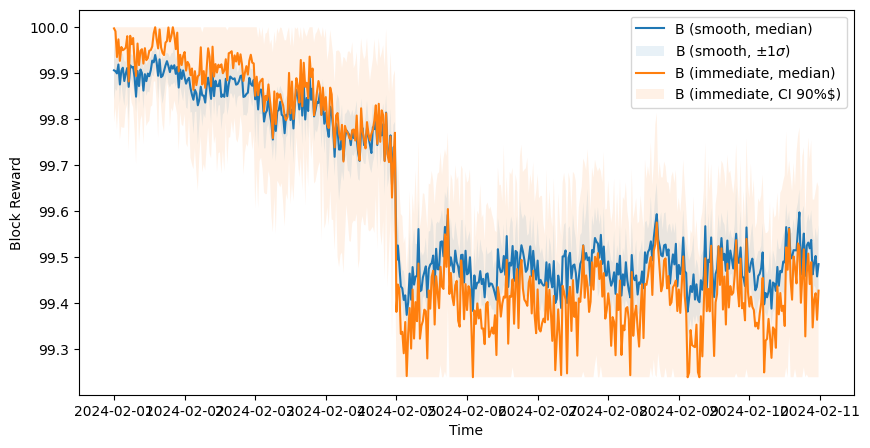

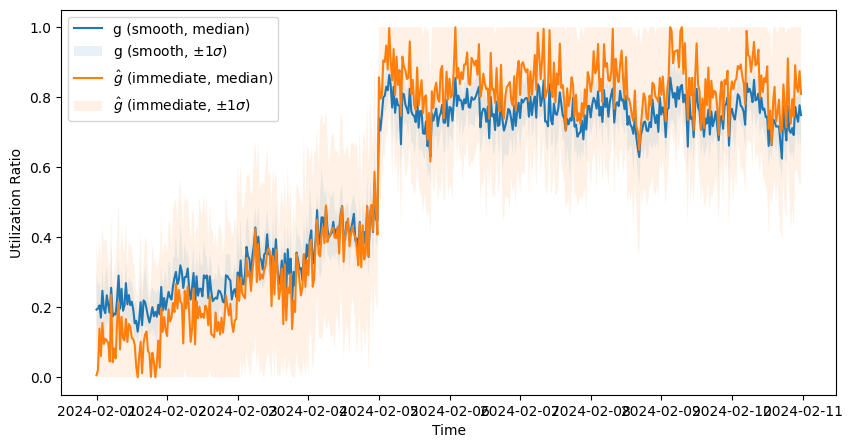

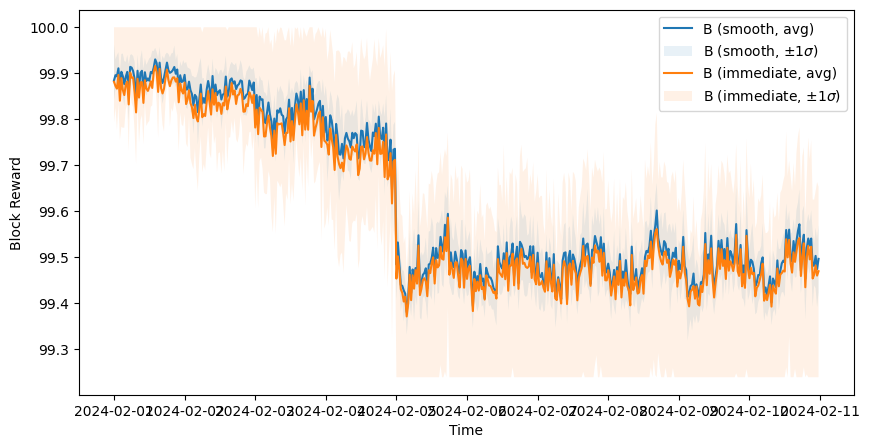

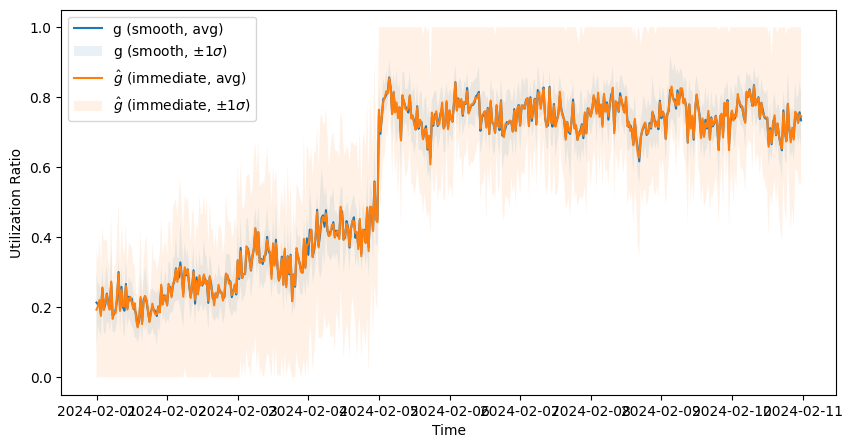

8607409.448215602
8605569.806823269


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd 
from datetime import timedelta
from mockseries.trend import LinearTrend, Switch
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
from mockseries.utils import datetime_range
from mockseries.utils import plot_timeseries
from datetime import datetime

N_t = N_days * 24 * 60 * 6 # Around 3 days of blocks

def B(g, c=c, d=d, S_r=S_r, F_bar=F_bar):
    b = (S_r - max(S_r - F_bar, 0)) / F_bar
    a = S_r - b * np.tanh(c * d)
    return a + b * np.tanh(-c * (g - d))

t = LinearTrend(0.1, time_unit=timedelta(days=1)) * Switch(datetime(2024, 2, 5), 1.0, 0.0)


seasonality = (SinusoidalSeasonality(amplitude=0.05, period=timedelta(days=1)) 
              + SinusoidalSeasonality(amplitude=0.01, period=timedelta(hours=1)) 
              + t
              + Switch(datetime(2024, 2, 5), 0, 0.8))

noise = RedNoise(mean=0.02, std=0.4, correlation=0.5)

timeseries = seasonality + noise


time_points = datetime_range(
    granularity=timedelta(seconds=10),
    start_time=datetime(2024, 2, 1),
    end_time=datetime(2024, 2, 1 + N_days),
)
ts_values = timeseries.generate(time_points=time_points)

y_1 = np.array([min(max(y_i, 0), 1.0) for y_i in ts_values])
y_2 = (y_1 - y_1.min()) / (y_1.max() -y_1.min())


tilde_B_y = B(y_2)

k = smooth_multiplier
g_hat = np.zeros(len(tilde_B_y))
for i, g_i in enumerate(y_2):
    if i == 0:
        g_i_hat = g_i
    elif i < N_threshold:
        g_i_hat = (g_hat[i-1] + g_i) / 2
    elif i >= N_threshold:
        g_i_hat = k * g_i + (1 - k) * g_hat[i-1]
    else:
        raise Exception
    g_hat[i] = g_i_hat

g = np.array(y_2)
g_hat = np.array(g_hat)
B_g = B(g)
B_g_hat = B(g_hat)

data = {'g': g, 'g_hat': g_hat, 'B': B_g_hat, 'B_tilde': B_g, 't': time_points}
df = pd.DataFrame(data).set_index('t')
avg_df = df.resample('30min').median()
upper_df = df.resample('30min').quantile(0.75)
lower_df = df.resample('30min').quantile(0.25)

def fanplot(col):
    plt.plot(avg_df.index, avg_df[col])
    lower = lower_df[col]
    upper = upper_df[col]
    plt.fill_between(avg_df.index, lower, upper, alpha=0.1)
    


plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, median)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, median)', 'B (immediate, CI 90%$)'])
plt.show()


plt.figure(figsize=(10, 5))
fanplot('g_hat')
fanplot('g')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, median)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, median)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()


avg_df = df.resample('30min').mean()

plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, avg)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, avg)', 'B (immediate, $\pm 1 \sigma$)'])
plt.show()

plt.figure(figsize=(10, 5))
fanplot('g_hat')
fanplot('g')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, avg)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, avg)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()


print(f"{df.B.sum()}")
print(f"{df.B_tilde.sum()}")

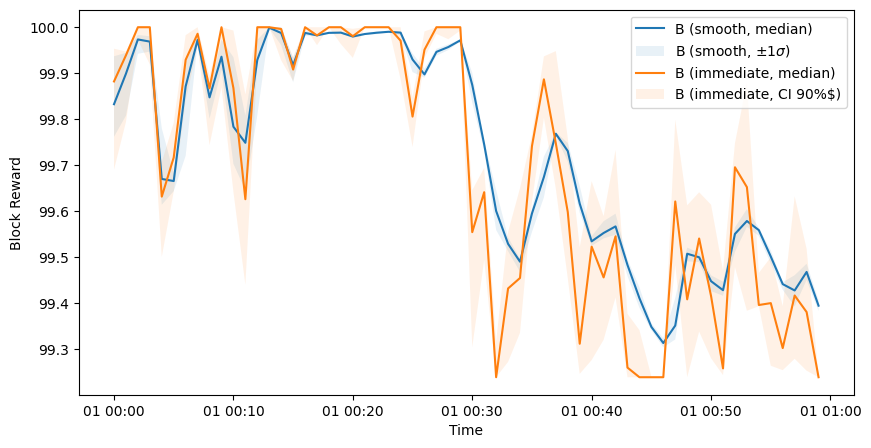

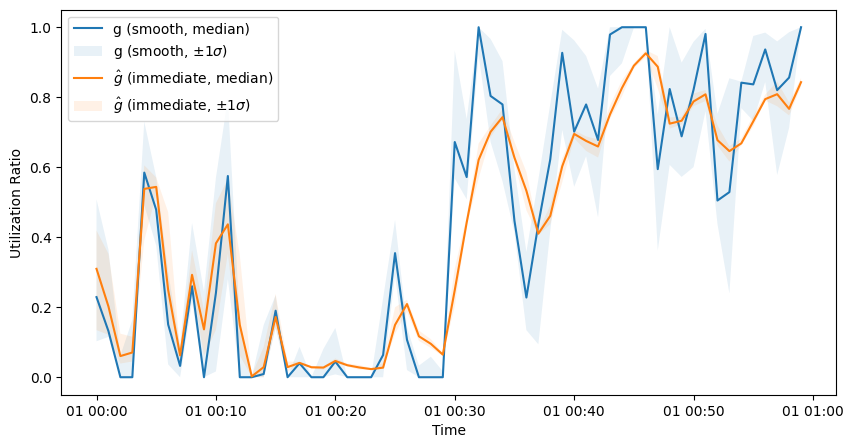

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd 
from datetime import timedelta
from mockseries.trend import LinearTrend, Switch
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
from mockseries.utils import datetime_range
from mockseries.utils import plot_timeseries
from datetime import datetime

N_t = N_days * 24 * 60 * 6 # Around 3 days of blocks
T = '1min'

def B(g, c=c, d=d, S_r=S_r, F_bar=F_bar):
    b = (S_r - max(S_r - F_bar, 0)) / F_bar
    a = S_r - b * np.tanh(c * d)
    return a + b * np.tanh(-c * (g - d))

t = LinearTrend(0.1, time_unit=timedelta(days=1)) * Switch(datetime(2024, 2, 5), 1.0, 0.0)


seasonality = Switch(datetime(2024, 2, 1, 0, 30, 0), 0, 0.8)

noise = RedNoise(mean=0.02, std=0.4, correlation=0.5)

timeseries = seasonality + noise


time_points = datetime_range(
    granularity=timedelta(seconds=10),
    start_time=datetime(2024, 2, 1, 0, 0, 0),
    end_time=datetime(2024, 2, 1, 1, 0, 0),
)
ts_values = timeseries.generate(time_points=time_points)

y_1 = np.array([min(max(y_i, 0), 1.0) for y_i in ts_values])
y_2 = (y_1 - y_1.min()) / (y_1.max() -y_1.min())


tilde_B_y = B(y_2)

k = smooth_multiplier
g_hat = np.zeros(len(tilde_B_y))
for i, g_i in enumerate(y_2):
    if i == 0:
        g_i_hat = g_i
    elif i < N_threshold:
        g_i_hat = (g_hat[i-1] + g_i) / 2
    elif i >= N_threshold:
        g_i_hat = k * g_i + (1 - k) * g_hat[i-1]
    else:
        raise Exception
    g_hat[i] = g_i_hat

g = np.array(y_2)
g_hat = np.array(g_hat)
B_g = B(g)
B_g_hat = B(g_hat)


data = {'g': g, 'g_hat': g_hat, 'B': B_g_hat, 'B_tilde': B_g, 't': time_points}
df = pd.DataFrame(data).set_index('t')
avg_df = df.resample(T).median()
upper_df = df.resample(T).quantile(0.75)
lower_df = df.resample(T).quantile(0.25)

def fanplot(col):
    plt.plot(avg_df.index, avg_df[col])
    lower = lower_df[col]
    upper = upper_df[col]
    plt.fill_between(avg_df.index, lower, upper, alpha=0.1)
    


plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, median)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, median)', 'B (immediate, CI 90%$)'])
plt.show()


plt.figure(figsize=(10, 5))
fanplot('g')
fanplot('g_hat')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, median)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, median)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()

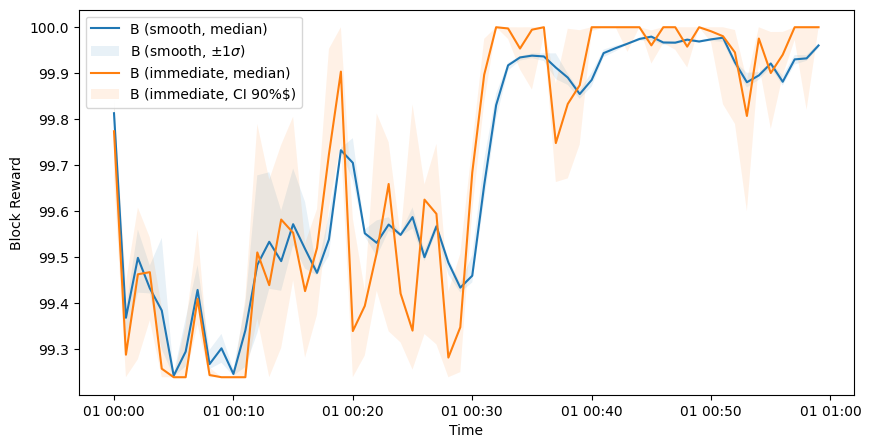

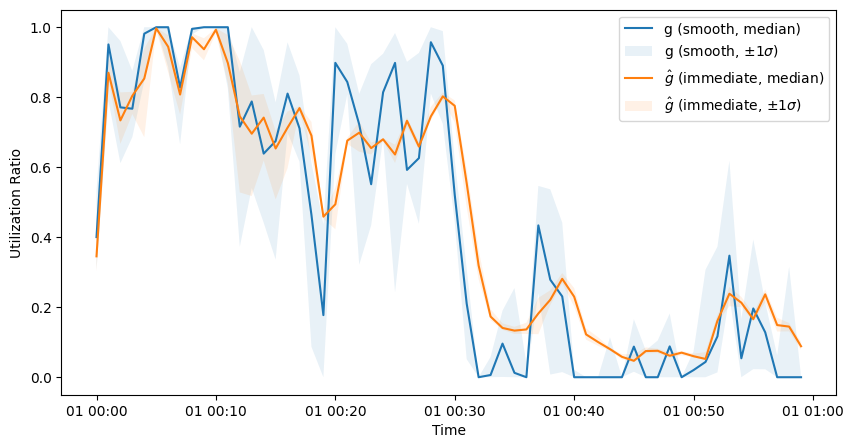

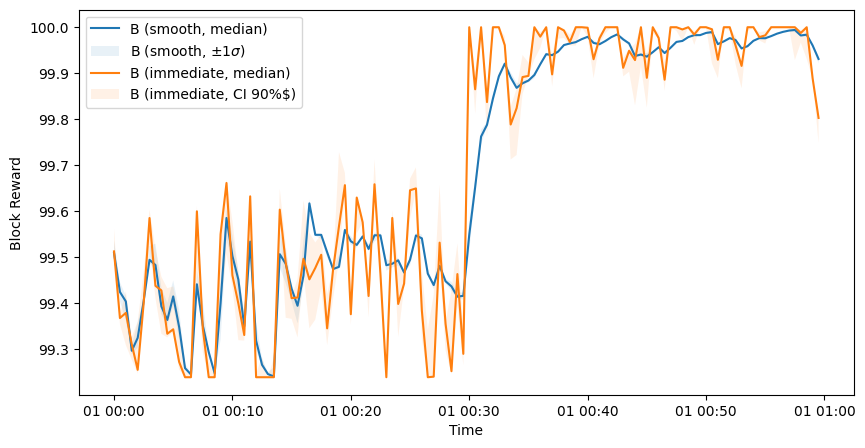

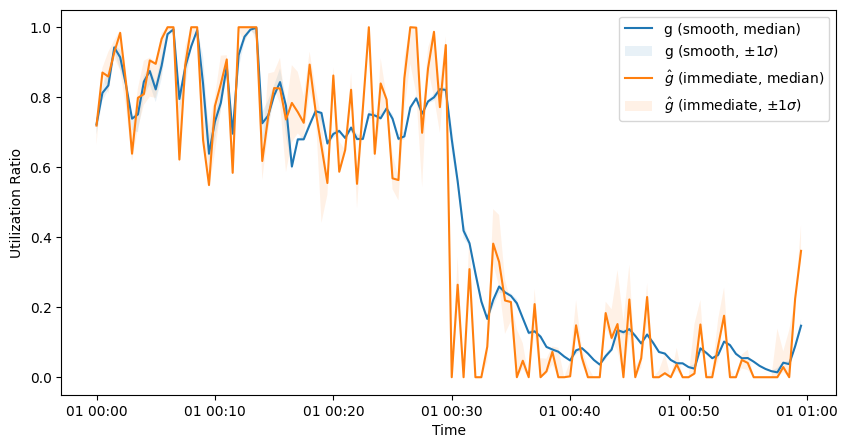

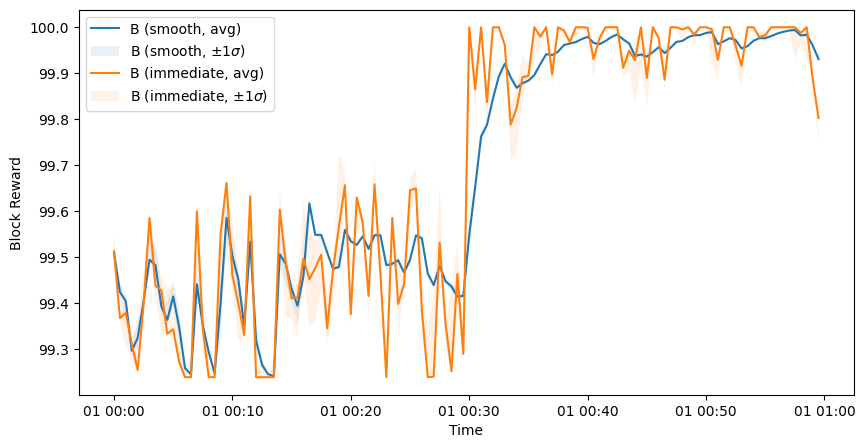

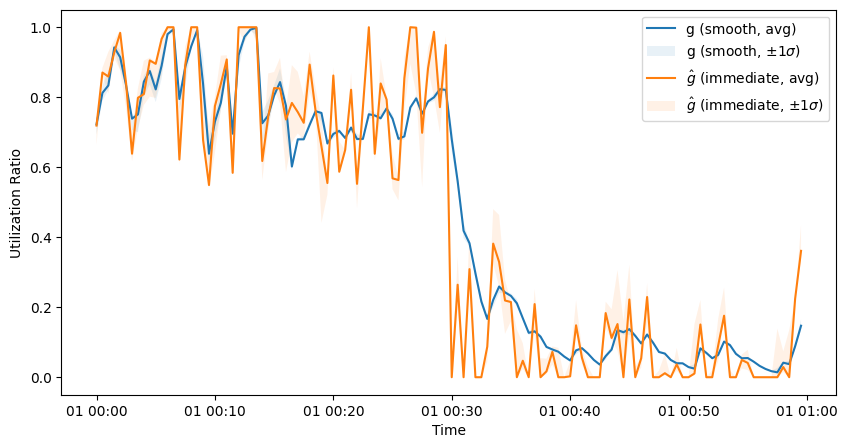

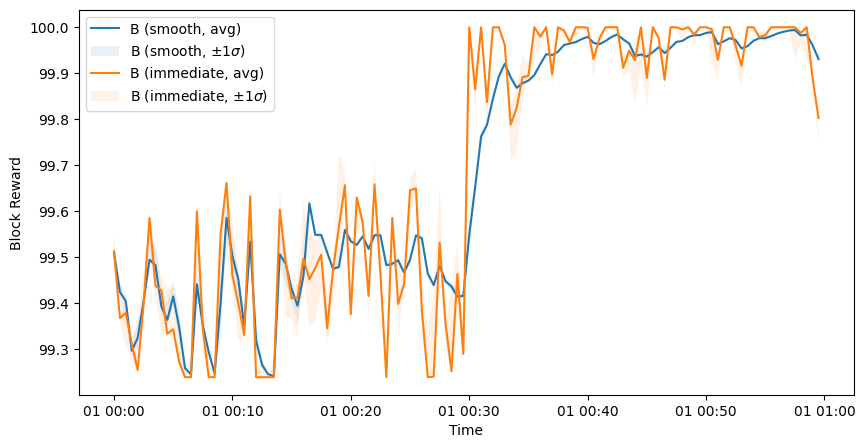

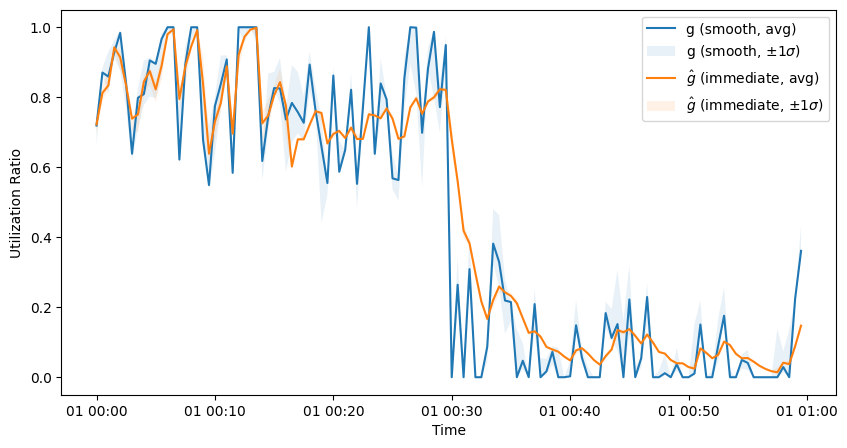

35888.28752334261
35888.327307928834


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd 
from datetime import timedelta
from mockseries.trend import LinearTrend, Switch
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
from mockseries.utils import datetime_range
from mockseries.utils import plot_timeseries
from datetime import datetime

N_t = N_days * 24 * 60 * 6 # Around 3 days of blocks
T = '1min'

def B(g, c=c, d=d, S_r=S_r, F_bar=F_bar):
    b = (S_r - max(S_r - F_bar, 0)) / F_bar
    a = S_r - b * np.tanh(c * d)
    return a + b * np.tanh(-c * (g - d))


seasonality = Switch(datetime(2024, 2, 1, 0, 30, 0), 0.8, 0.0)

noise = RedNoise(mean=0.02, std=0.4, correlation=0.5)

timeseries = seasonality + noise


time_points = datetime_range(
    granularity=timedelta(seconds=10),
    start_time=datetime(2024, 2, 1, 0, 0, 0),
    end_time=datetime(2024, 2, 1, 1, 0, 0),
)
ts_values = timeseries.generate(time_points=time_points)

y_1 = np.array([min(max(y_i, 0), 1.0) for y_i in ts_values])
y_2 = (y_1 - y_1.min()) / (y_1.max() -y_1.min())


tilde_B_y = B(y_2)

k = smooth_multiplier
g_hat = np.zeros(len(tilde_B_y))
for i, g_i in enumerate(y_2):
    if i == 0:
        g_i_hat = g_i
    elif i < N_threshold:
        g_i_hat = (g_hat[i-1] + g_i) / 2
    elif i >= N_threshold:
        g_i_hat = k * g_i + (1 - k) * g_hat[i-1]
    else:
        raise Exception
    g_hat[i] = g_i_hat

g = np.array(y_2)
g_hat = np.array(g_hat)
B_g = B(g)
B_g_hat = B(g_hat)


data = {'g': g, 'g_hat': g_hat, 'B': B_g_hat, 'B_tilde': B_g, 't': time_points}
df = pd.DataFrame(data).set_index('t')
avg_df = df.resample(T).median()
upper_df = df.resample(T).quantile(0.75)
lower_df = df.resample(T).quantile(0.25)

def fanplot(col):
    plt.plot(avg_df.index, avg_df[col])
    lower = lower_df[col]
    upper = upper_df[col]
    plt.fill_between(avg_df.index, lower, upper, alpha=0.1)
    


plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, median)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, median)', 'B (immediate, CI 90%$)'])
plt.show()


plt.figure(figsize=(10, 5))
fanplot('g')
fanplot('g_hat')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, median)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, median)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd 
from datetime import timedelta
from mockseries.trend import LinearTrend, Switch
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
from mockseries.utils import datetime_range
from mockseries.utils import plot_timeseries
from datetime import datetime

N_t = N_days * 24 * 60 * 6 # Around 3 days of blocks
T = '30s'

def B(g, c=c, d=d, S_r=S_r, F_bar=F_bar):
    b = (S_r - max(S_r - F_bar, 0)) / F_bar
    a = S_r - b * np.tanh(c * d)
    return a + b * np.tanh(-c * (g - d))

seasonality = Switch(datetime(2024, 2, 1, 0, 30, 0), 0.8, 0.0)

noise = RedNoise(mean=0.02, std=0.2, correlation=0.5)

timeseries = seasonality + noise


time_points = datetime_range(
    granularity=timedelta(seconds=10),
    start_time=datetime(2024, 2, 1, 0, 0, 0),
    end_time=datetime(2024, 2, 1, 1, 0, 0),
)
ts_values = timeseries.generate(time_points=time_points)

y_1 = np.array([min(max(y_i, 0), 1.0) for y_i in ts_values])
y_2 = (y_1 - y_1.min()) / (y_1.max() -y_1.min())


tilde_B_y = B(y_2)

k = smooth_multiplier
g_hat = np.zeros(len(tilde_B_y))
for i, g_i in enumerate(y_2):
    if i == 0:
        g_i_hat = g_i
    elif i < N_threshold:
        g_i_hat = (g_hat[i-1] + g_i) / 2
    elif i >= N_threshold:
        g_i_hat = k * g_i + (1 - k) * g_hat[i-1]
    else:
        raise Exception
    g_hat[i] = g_i_hat

g = np.array(y_2)
g_hat = np.array(g_hat)
B_g = B(g)
B_g_hat = B(g_hat)


data = {'g': g, 'g_hat': g_hat, 'B': B_g_hat, 'B_tilde': B_g, 't': time_points}
df = pd.DataFrame(data).set_index('t')
avg_df = df.resample(T).median()
upper_df = df.resample(T).quantile(0.75)
lower_df = df.resample(T).quantile(0.25)

def fanplot(col):
    plt.plot(avg_df.index, avg_df[col])
    lower = lower_df[col]
    upper = upper_df[col]
    plt.fill_between(avg_df.index, lower, upper, alpha=0.1)
    


plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, median)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, median)', 'B (immediate, CI 90%$)'])
plt.show()


plt.figure(figsize=(10, 5))
fanplot('g_hat')
fanplot('g')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, median)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, median)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()

avg_df = df.resample(T).median()

plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, avg)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, avg)', 'B (immediate, $\pm 1 \sigma$)'])
plt.show()

plt.figure(figsize=(10, 5))
fanplot('g_hat')
fanplot('g')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, avg)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, avg)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()

plt.figure(figsize=(10, 5))
fanplot('B')
fanplot('B_tilde')
plt.ylabel('Block Reward')
plt.xlabel('Time')
plt.legend(['B (smooth, avg)', 'B (smooth, $\pm 1 \sigma$)', 'B (immediate, avg)', 'B (immediate, $\pm 1 \sigma$)'])
plt.show()

plt.figure(figsize=(10, 5))
fanplot('g')
fanplot('g_hat')
plt.ylabel('Utilization Ratio')
plt.xlabel('Time')
plt.legend(['g (smooth, avg)', 'g (smooth, $\pm 1 \sigma$)', '$\hat g$ (immediate, avg)', '$\hat g$ (immediate, $\pm 1 \sigma$)'])
plt.show()

print(f"{df.B.sum()}")
print(f"{df.B_tilde.sum()}")